In [ ]:
!pip install neuralprophet

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

#Import Prophet model
from neuralprophet import NeuralProphet, set_log_level

#Import logging
import logging


set_log_level("ERROR")
logging.getLogger("prophet").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")


import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


In [ ]:
# Data source: https://www.kaggle.com/datasets/sushobhitlutade/inventorysupply-chain-managementscm-superstore/data?select=Brand.csv
# US holiday 2004-2021 data: https://www.kaggle.com/datasets/donnetew/us-holiday-dates-2004-2021?select=US+Holiday+Dates+%282004-2021%29.csv

#Importing and cleaning data

In [ ]:
#download data
# https://drive.google.com/file/d/1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7/view?usp=sharing
# https://drive.google.com/file/d/1gevzcsdgYnpcMVUJBhOe3z6QsIPK7GJZ/view?usp=sharing

dwn_url='https://drive.google.com/uc?id='
# df_id = dwn_url+"1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7"
df_trans = pd.read_csv(dwn_url+"1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7") #transactions data

#deletes white spaces on column tittles
df_trans.columns = [col.strip() for col in df_trans.columns]

#Clean transaction table, delete unnecessary columns (Payment_Method, Customer_Cart, Cashier)
df_trans = df_trans.drop(columns=['Payment_Method', 'CustomerCart_CustomerID','Cashier_CashierID'])

#transforms date column to datetime format
df_trans["Transaction_date"] = pd.to_datetime(df_trans["Transaction_date"], format = "%Y-%m-%d")

#Clean data to show only 2014-2017 data
df_trans=df_trans[df_trans["Transaction_date"].dt.year <= 2017]


In [ ]:
#create column for Units Sold
df_trans['Units_Sold'] = df_trans['Quantity']

#delete column named 'Quantity' for better column lableling/understanding
df_trans = df_trans.drop(columns=['Quantity'])

#add columns to Transaction Table
df_trans['Cat-SubCat_ID']= df_trans['Products_ProductID'].str[:6] #Initials of category and subcategory
df_trans['Cat_ID']= df_trans['Products_ProductID'].str[:3] #first 3 letters of Category ID
df_trans['SubCat_ID']= df_trans['Products_ProductID'].str[4:6] #first 2 letters of SubCategory ID
df_trans['Quarter'] = df_trans['Transaction_date'].dt.quarter
df_trans['Month']= df_trans['Transaction_date'].dt.month
df_trans['Day_of_Year']= df_trans['Transaction_date'].dt.day_of_year
df_trans['Year-Month'] = df_trans['Transaction_date'].dt.to_period('M')
df_trans['Day_of_the_Week']= df_trans['Transaction_date'].dt.day_name()


In [ ]:
df_trans.head()

,Transaction_date,Subtotal,Taxes,DiscountPrice,TotalAmount,Products_ProductID,Units_Sold,Cat-SubCat_ID,Cat_ID,SubCat_ID,Quarter,Month,Day_of_Year,Year-Month,Day_of_the_Week
0,2016-11-11,261.96,11.46,78.59,273.42,FUR-BO-10001798,2,FUR-BO,FUR,BO,4,11,316,2016-11,Friday
1,2016-11-11,512.36,22.42,153.71,534.77,FUR-CH-10000454,3,FUR-CH,FUR,CH,4,11,316,2016-11,Friday
2,2016-06-16,14.62,0.91,0.00,15.53,OFF-LA-10000240,2,OFF-LA,OFF,LA,2,6,168,2016-06,Thursday
3,2015-10-18,957.58,41.89,287.27,999.47,FUR-TA-10000577,5,FUR-TA,FUR,TA,4,10,291,2015-10,Sunday
4,2015-10-18,27.96,1.57,2.80,29.53,OFF-ST-10000760,2,OFF-ST,OFF,ST,4,10,291,2015-10,Sunday


In [ ]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9952 entries, 0 to 9993
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Transaction_date    9952 non-null   datetime64[ns]
 1   Subtotal            9952 non-null   float64       
 2   Taxes               9952 non-null   float64       
 3   DiscountPrice       9952 non-null   float64       
 4   TotalAmount         9952 non-null   float64       
 5   Products_ProductID  9952 non-null   object        
 6   Units_Sold          9952 non-null   int64         
 7   Cat-SubCat_ID       9952 non-null   object        
 8   Cat_ID              9952 non-null   object        
 9   SubCat_ID           9952 non-null   object        
 10  Quarter             9952 non-null   int32         
 11  Month               9952 non-null   int32         
 12  Day_of_Year         9952 non-null   int32         
 13  Year-Month          9952 non-null   period[M]     
 1

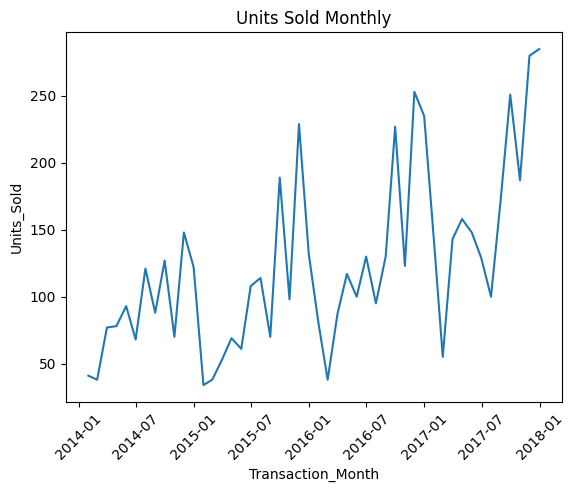

In [ ]:
# Instead of one item, we choose one sub-catagory 'OFF-BI'.
df_OFF_BI = df_trans.query("`Cat-SubCat_ID` == 'OFF-BI'")
# Grouping data by number of units sold each month.
df_M = df_OFF_BI.groupby(pd.Grouper(key="Transaction_date", freq='M'))[['Units_Sold']].sum().reset_index()

# Plotting dataframe
plt.plot(df_M["Transaction_date"], df_M['Units_Sold'])
plt.ylabel('Units_Sold')
plt.xlabel('Transaction_Month')
plt.xticks(rotation=45)
plt.title('Units Sold Monthly')
plt.show()



In [ ]:
#Renaming Columns to meet Neural Prophet format
df_M.columns = ['ds', 'y']
df_M.head()

,ds,y
0,2014-01-31,41
1,2014-02-28,38
2,2014-03-31,77
3,2014-04-30,78
4,2014-05-31,93


#Training Model

In [ ]:
m = NeuralProphet()
model = m.fit(df_M, freq="M")
m.set_plotting_backend('plotly-static')

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/204 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

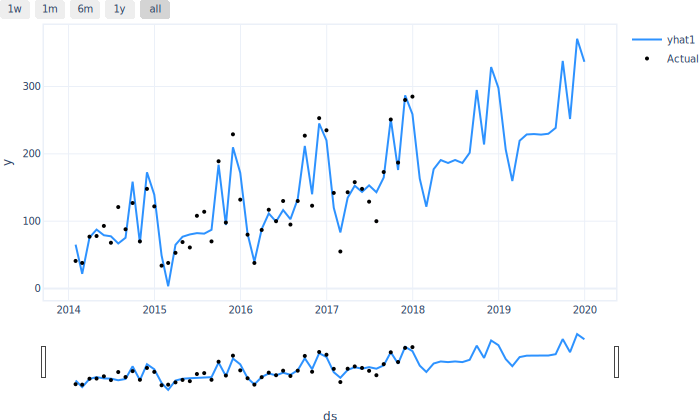

In [ ]:
future = m.make_future_dataframe(df_M, periods=24, n_historic_predictions=len(df_M))
forecast = m.predict(future)
m.plot(forecast)

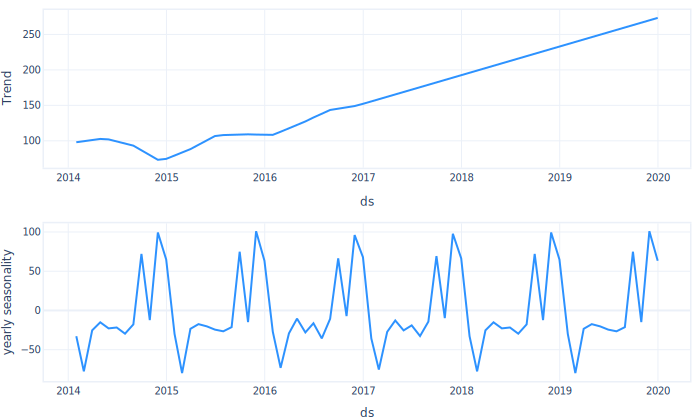

In [ ]:
m.plot_components(forecast)

Questions:

*   Why does the 2nd graph in m.plot components show a stagnant value, and there's <0 value
*   Does it base in historical data, how far from the latest data does it derive from?



#Adding complexity to model:
- Seasonality
- Trend
- freequency
- Holidays

In [ ]:
df_train = df_M[df_M['ds']<='2017-5-31']
df_test = df_M[df_M['ds']>'2017-5-31']

m = NeuralProphet(seasonality_mode="multiplicative", learning_rate=0.1)
    # Using multiplicative seasonality mode as the data shows growth along with seasonality trend.
m = m.add_country_holidays(country_name='US')
m.set_plotting_backend('plotly-static')
m.fit(df_train, freq="M", epochs=1000).tail()

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
995,0.005151,0.0,10.913152,12.594111,0.005698,0.0,995
996,0.005168,0.0,8.816413,10.958545,0.004416,0.0,996
997,0.005146,0.0,8.962070,11.111869,0.004410,0.0,997
998,0.005159,0.0,12.875714,14.484643,0.007490,0.0,998
999,0.005153,0.0,9.901690,12.047874,0.004745,0.0,999


Predicting: |          | 0/? [00:00<?, ?it/s]

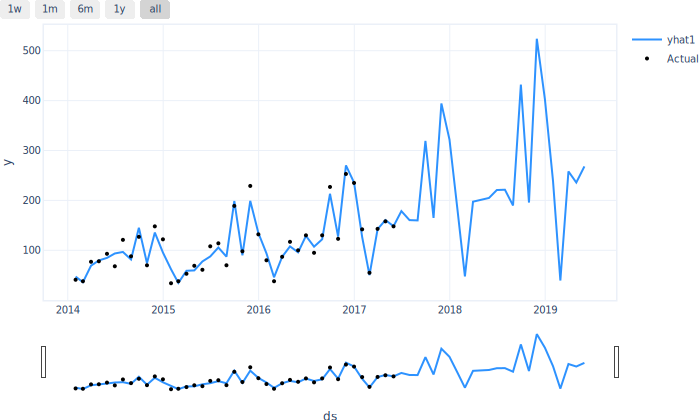

In [ ]:
future = m.make_future_dataframe(df=df_train, periods=24, n_historic_predictions=len(df_train))
forecast = m.predict(future)
m.plot(forecast)


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

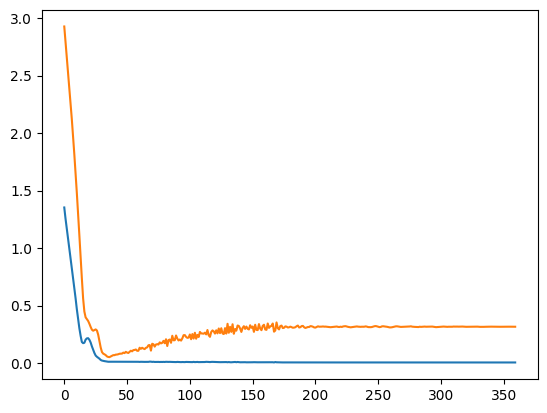

In [ ]:
m = NeuralProphet(seasonality_mode="multiplicative", learning_rate=0.1)
m.set_plotting_backend("plotly-static")

df = df_M
df_train, df_test = m.split_df(df=df, freq="M", valid_p=0.2)

metrics = m.fit(df=df_train, freq="M", validation_df=df_test, progress="plot")

In [ ]:
metrics.tail(1)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
359,87.656044,104.585793,0.315764,0.0,359,0.005063,0.0,10.6474,13.015193,0.00502,0.0


In [ ]:
METRICS = ["MAE", "RMSE"]
METRICS_VAL = ["MAE_val", "RMSE_val"]
params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}

# Split data into folds
folds = NeuralProphet(**params).crossvalidation_split_df(df_M,
                                                         freq="M",
                                                         k=5,
                                                         fold_pct=0.1,
                                                         fold_overlap_pct=0.5)

# Train and evaluate across folds
metrics = []
for df_train, df_test in folds:
    m = NeuralProphet()
    m.fit(df_train, freq="M")
    forecast = m.predict(df_test)
    metrics.append(m.test(df_test))

# Analyze results
avg_rmse = sum(fold['RMSE_val'] for fold in metrics) / len(metrics) # column name for RMSE is RMSE_val
print("Average RMSE:", avg_rmse)

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.06582876294851303    │
│          MAE_val          │     32.67680358886719     │
│         RMSE_val          │       39.400390625        │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.02637702412903309    │
│          MAE_val          │    14.377517700195312     │
│         RMSE_val          │     24.64466667175293     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.08905226737260818    │
│          MAE_val          │     34.13154602050781     │
│         RMSE_val          │     46.12983322143555     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.04568428173661232    │
│          MAE_val          │     28.29358673095703     │
│         RMSE_val          │    32.267913818359375     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.07584310322999954    │
│          MAE_val          │     36.89006805419922     │
│         RMSE_val          │    41.762298583984375     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Average RMSE: 0    36.841021
Name: RMSE_val, dtype: float64


In [ ]:
##play around

metrics_train = pd.DataFrame(columns=METRICS)
metrics_test = pd.DataFrame(columns=METRICS_VAL)

for df_train, df_test in folds:
    m = NeuralProphet(**params)
    m.set_plotting_backend("plotly-static")
    train = m.fit(df=df_train, freq="M")
    test = m.test(df=df_test)

    # convert the Series object (train[METRICS].iloc[-1] and test[METRICS_VAL].iloc[-1]) to a DataFrame using .to_frame() and then transpose it using .T to get a single-row DataFrame.

    metrics_train = pd.concat([metrics_train, train[METRICS].iloc[-1].to_frame().T])
    metrics_test = pd.concat([metrics_test, test[METRICS_VAL].iloc[-1].to_frame().T])

# Calculate average metrics
avg_metrics_train = metrics_train.mean()
avg_metrics_test = metrics_test.mean()

print("Average Training Metrics (Monthly):", avg_metrics_train)
print("Average Testing Metrics (Monthly):", avg_metrics_test)


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.06980660557746887    │
│          MAE_val          │    32.820037841796875     │
│         RMSE_val          │     40.91881561279297     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.19410955905914307    │
│          MAE_val          │     65.61273193359375     │
│         RMSE_val          │     72.26626586914062     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.13251368701457977    │
│          MAE_val          │     45.02402877807617     │
│         RMSE_val          │    57.269813537597656     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.06507450342178345    │
│          MAE_val          │     38.05034637451172     │
│         RMSE_val          │    38.511714935302734     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.056922562420368195    │
│          MAE_val          │     33.3566780090332      │
│         RMSE_val          │    35.981876373291016     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Average Training Metrics (Monthly): MAE     10.395115
RMSE    12.674529
dtype: float64
Average Testing Metrics (Monthly): MAE_val     42.972765
RMSE_val    48.989697
dtype: float64


Notes:

The *training metrics* show that the model's predictions are off by an average of about 10.90 units (MAE) and 13.28 units (RMSE) on the training data.

The *testing metrics* indicate that the model's predictions are off by an average of about 40.44 units (MAE_val) and 47.20 units (RMSE_val) on the validation data.

There is a significant difference between the training and testing metrics, indicating that the model may be overfitting to the training data and not generalizing well to the validation data.

The variability in MAE_val and RMSE_val across different folds suggests that the model's performance can vary depending on the data split.

In [ ]:
from sklearn.model_selection import ParameterGrid

# Removed Hyperparameter

In [ ]:
# Now try to calculate and display the descriptive statistics
desc_stats = metrics_test.describe()
if desc_stats.empty:
    print("Warning: metrics_test DataFrame is still empty. Check data processing.")
else:
    print(desc_stats.loc[["mean", "std", "min", "max"]])

        MAE_val   RMSE_val
mean  42.972765  48.989697
std   13.569755  15.447408
min   32.820038  35.981876
max   65.612732  72.266266


### 3-Phase Train, validate and Test evaluation

In [ ]:
m = NeuralProphet(seasonality_mode="multiplicative", learning_rate=0.1)
m.set_plotting_backend("plotly-static")

df = df_M
# create a test holdout set:
df_train_val, df_test = m.split_df(df=df, freq="MS", valid_p=0.2)
# create a validation holdout set:
df_train, df_val = m.split_df(df=df_train_val, freq="MS", valid_p=0.2)

# fit a model on training data and evaluate on validation set.
metrics_train1 = m.fit(df=df_train, freq="MS")
metrics_val = m.test(df=df_val)

# refit model on training and validation data and evaluate on test set.
m = NeuralProphet(seasonality_mode="multiplicative", learning_rate=0.1)
m.set_plotting_backend("plotly-static")
metrics_train2 = m.fit(df=df_train_val, freq="MS")
metrics_test = m.test(df=df_test)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.16856524348258972    │
│          MAE_val          │     37.75135040283203     │
│         RMSE_val          │     46.44036865234375     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.30952298641204834    │
│          MAE_val          │     86.24890899658203     │
│         RMSE_val          │    102.37490844726562     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

In [ ]:
metrics_train1["split"] = "train1"
metrics_train2["split"] = "train2"
metrics_val["split"] = "validate"
metrics_test["split"] = "test"
pd.concat([metrics_train1.tail(1), metrics_train2.tail(1), metrics_val, metrics_test]).drop(columns=["RegLoss"])

,train_loss,reg_loss,MAE,RMSE,Loss,epoch,split,MAE_val,RMSE_val,Loss_test,RegLoss_test
399,0.008351,0.0,8.871954,10.951150,0.008351,399.0,train1,NaN,NaN,NaN,NaN
359,0.004613,0.0,10.044712,12.264851,0.004546,359.0,train2,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,validate,37.751350,46.440369,0.168565,0.0
0,NaN,NaN,NaN,NaN,NaN,NaN,test,86.248909,102.374908,0.309523,0.0


### Weekly

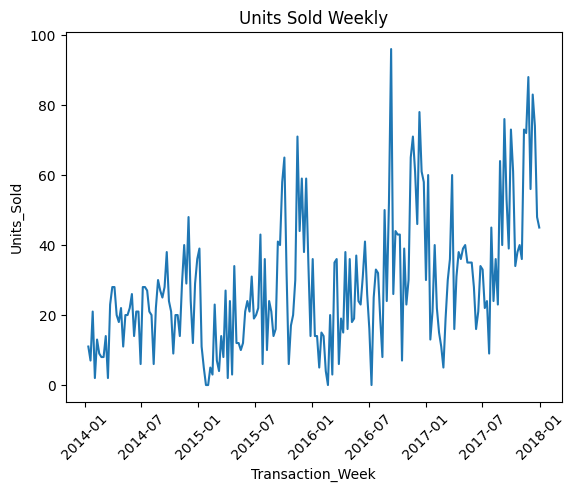

In [ ]:
df_OFF_BI = df_trans.query("`Cat-SubCat_ID` == 'OFF-BI'")

# Grouping data by number of units sold each week
df_W = df_OFF_BI.groupby(pd.Grouper(key="Transaction_date", freq='W'))[['Units_Sold']].sum().reset_index()

# Plotting dataframe
plt.plot(df_W["Transaction_date"], df_W['Units_Sold'])
plt.ylabel('Units_Sold')
plt.xlabel('Transaction_Week')
plt.xticks(rotation=45)
plt.title('Units Sold Weekly')
plt.show()

In [ ]:
#Renaming Columns to meet Neural Prophet format - Weekly
df_W.columns = ['ds', 'y']
df_W.head()

,ds,y
0,2014-01-12,11
1,2014-01-19,7
2,2014-01-26,21
3,2014-02-02,2
4,2014-02-09,13


In [ ]:
m = NeuralProphet()
m.set_plotting_backend('plotly')
model = m.fit(df_W, freq="W", epochs=1000).tail()

print("Model summary:\n", model) # Print the model summary

#df_train is not defined....I dont think the right model is being fitted

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Model summary:
      train_loss  reg_loss       MAE       RMSE      Loss  RegLoss  epoch
995    0.035956       0.0  9.041315  11.384451  0.035956      0.0    995
996    0.035952       0.0  9.044291  11.267303  0.035952      0.0    996
997    0.035963       0.0  9.049246  11.240544  0.035963      0.0    997
998    0.035946       0.0  9.049523  11.322641  0.035946      0.0    998
999    0.035949       0.0  9.042662  11.289028  0.035949      0.0    999


In [ ]:
future = m.make_future_dataframe(df=df_W, periods=26, n_historic_predictions=len(df_W)) # 26 weeks for the next 6 months
forecast = m.predict(future)

# Plot the forecast
fig_forecast = m.plot(forecast)
fig_forecast.show()

# Plotting the forecast components
# fig_components = m.plot_components(forecast)
# fig_components.show()

# why is the output empty? --> changed df from 'df_train' to 'df_W'

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Define the number of weeks for training and forecasting
training_weeks = len(df_W) - 26  # Use all data except last 26 weeks for training
forecast_weeks = 26  # Forecast the next 26 weeks

# Splitting data into training and test sets
df_train_W = df_W[df_W['ds']<='2017-5-31']
df_test_W = df_W.[df_W['ds']>'2017-5-31']

# Debug: Print the size of training and test sets
print("Training set size:", df_train_W.shape)
print("Test set size:", df_test_W.shape)

SyntaxError: invalid syntax (<ipython-input-28-4b7908cd51da>, line 7)

In [ ]:
# Generating future dataframe for predictions (forecasting the next 24 weeks)
future = m.make_future_dataframe(df=df_train_W, periods=forecast_weeks, n_historic_predictions=len(df_train_W))

# Debug: Print the future dataframe
print("Future dataframe head:\n", future.head())

# Making predictions
forecast = m.predict(future)

# Debug: Print the forecast dataframe
print("Forecast head:\n", forecast.head())

# Plotting the forecast
fig_forecast = m.plot(forecast)
if fig_forecast is not None:
    fig_forecast.show()
else:
    print("Forecast plot is empty.")

# Plotting the forecast components
fig_components = m.plot_components(forecast)
if fig_components is not None:
    fig_components.show()
else:
    print("Components plot is empty.")



Notes: it appears that the model is making predictions but they seem to be far from the actual values.

In [ ]:
# Compare Actuals vs Forecast to investigate
plt.figure(figsize=(10, 6))
plt.plot(df_W['ds'], df_W['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat1'], label='Forecast', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Forecasted Units Sold')
plt.legend()
plt.show()

In [ ]:
# Re-initialize NeuralProphet for weekly model fitting

m_weekly = NeuralProphet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_changepoints=50,
    learning_rate=0.01
)
m_weekly = m_weekly.add_country_holidays(country_name='US')
m_weekly.set_plotting_backend('plotly')
m_weekly.fit(df_train_W, freq="W", epochs=1000)

future_weekly = m_weekly.make_future_dataframe(df=df_train_W, periods=forecast_weeks, n_historic_predictions=len(df_train_W))
forecast_weekly = m_weekly.predict(future_weekly)

# Plotting the forecast for weekly data
fig_forecast = m_weekly.plot(forecast_weekly)
if fig_forecast:
    fig_forecast.show()
else:
    print("Forecast plot is empty.")

# Plotting the forecast components for weekly data
fig_components = m_weekly.plot_components(forecast_weekly)
if fig_components:
    fig_components.show()
else:
    print("Components plot is empty.")

# Additional plot to compare actual vs forecasted for weekly data
plt.figure(figsize=(10, 6))
plt.plot(df_W['ds'], df_W['y'], label='Actual')
plt.plot(forecast_weekly['ds'], forecast_weekly['yhat1'], label='Forecast', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Forecasted Units Sold')
plt.legend()
plt.show()

Notes: The updated plot shows a much closer alignment between the actual and forecasted units sold, which is a positive improvement. Need fine-tuning of model paramaters.

In [ ]:
# Compare with Increased n_changepoints to capture more potential changes in trends and lowered learning_rate to improve convergence. Increased Epochs for better fitting.

In [ ]:
m = NeuralProphet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_changepoints=100,
    learning_rate=0.005
)

model = m.fit(df_train_W, freq="W", epochs=1500).tail()

print("Model summary:\n", model)


In [ ]:
future = m.make_future_dataframe(df=df_train_W, periods=forecast_weeks, n_historic_predictions=len(df_train_W))
print("Future dataframe head:\n", future.head())


In [ ]:
forecast = m.predict(future)
print("Forecast head:\n", forecast.head())


In [ ]:
fig_forecast = m.plot(forecast)
if fig_forecast:
    fig_forecast.show()
else:
    print("Forecast plot is empty.")

# Plotting the forecast components
fig_components = m.plot_components(forecast)
if fig_components:
    fig_components.show()
else:
    print("Components plot is empty.")

# Plot the actual data and predictions for comparison
plt.figure(figsize=(10, 6))
plt.plot(df_W['ds'], df_W['y'], label='Actual', linestyle='dashed')
plt.plot(forecast['ds'], forecast['yhat1'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Forecasted Units Sold')
plt.legend()
plt.show()

Notes:

The alignment between the actual and forecasted values indicates how well the model is performing. The model seems to capture the overall trend and some seasonality, but there are deviations.

Trend appears to be generally increasing. Compared to yearly seasonality, weekly seasonality captures more granular patters that repeat every week such as weekend vs weekday sales difference. Yearly seasonality captures broader trends and patterns such as holiday sales spikes.

Cross-validation weekly

In [ ]:
# Define metrics and parameters for weekly data
METRICS_W = ["MAE", "RMSE"]
METRICS_VAL_W = ["MAE_val", "RMSE_val"]
params_W = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}

# Split data into folds for weekly data
folds_W = NeuralProphet(**params_W).crossvalidation_split_df(df_W, freq="W", k=5, fold_pct=0.1, fold_overlap_pct=0.5)

# Train and evaluate across folds for weekly data
metrics_train_W = pd.DataFrame(columns=METRICS_W)
metrics_test_W = pd.DataFrame(columns=METRICS_VAL_W)

for df_train, df_test in folds_W:
    m = NeuralProphet(**params_W)
    m.set_plotting_backend("plotly-static")
    train = m.fit(df=df_train_W, freq="W")
    test = m.test(df=df_test_W)

    # Collect metrics for weekly data
    metrics_train_W = pd.concat([metrics_train_W, train[METRICS_W].iloc[-1].to_frame().T])
    metrics_test_W = pd.concat([metrics_test_W, test[METRICS_VAL_W].iloc[-1].to_frame().T])

# Calculate average metrics for weekly data
avg_metrics_train_W = metrics_train_W.mean()
avg_metrics_test_W = metrics_test_W.mean()

print("Average Training Metrics (Weekly):", avg_metrics_train_W)
print("Average Testing Metrics (Weekly):", avg_metrics_test_W)

Notes:

The *training metrics* indicate that on average, the model's predictions are off by about 8.31 units (MAE) and 10.63 units (RMSE) on the training data.

The *testing metrics* indicate that on average, the model's predictions are off by about 12.83 units (MAE_val) and 15.73 units (RMSE_val) on the validation data.

The results are not bad but show that there is room for improvement, especially since some folds show higher errors.

Consistency in performance across folds is desirable, and in this case, Fold 2 shows significantly higher error rates, which might need further investigation.


***ALL THE ABOVE MUST BE REVIEWED BASED ON CORRECTIONS.***

#Semi-monthly model

In [ ]:
df_OFF_BI = df_trans.query("`Cat-SubCat_ID` == 'OFF-BI'")

# Grouping data by number of units sold each week
df_SM = df_OFF_BI.groupby(pd.Grouper(key="Transaction_date", freq='SM'))[['Units_Sold']].sum().reset_index()

# Plotting dataframe
plt.plot(df_SM["Transaction_date"], df_SM['Units_Sold'])
plt.ylabel('Units_Sold')
plt.xlabel('Transaction_Semi-monthly')
plt.xticks(rotation=45)
plt.title('Units Sold Semi-monthly')
plt.show()

In [ ]:
#Renaming Columns to meet Neural Prophet format - BI-Weekly
df_SM.columns = ['ds', 'y']
df_SM.head()

In [ ]:
df_train_SM = df_SM[df_SM['ds']<='2017-5-31']
df_test_SM = df_SM[df_SM['ds']>'2017-5-31']

m = NeuralProphet()
m.set_plotting_backend('plotly')
model = m.fit(df_train_SM, freq="SM", epochs=1000).tail()

print("Model summary:\n", model) # Print the model summary


In [ ]:
# Define the number of weeks for training and forecasting
training_SM = len(df_SM) - 12  # Use all data except last 26 weeks for training
forecast_SM = 26  # Forecast the next 26 weeks

# Splitting data into training and test sets
df_train_SM = df_SM.iloc[:training_SM]
df_test_SM = df_SM.iloc[training_SM:]

# Debug: Print the size of training and test sets
print("Training set size:", df_train_SM.shape)
print("Test set size:", df_test_SM.shape)

In [ ]:
# Generating future dataframe for predictions (forecasting the next 24 weeks)
future = m.make_future_dataframe(df=df_train_SM, periods=forecast_SM, n_historic_predictions=len(df_train_SM))

# Debug: Print the future dataframe
print("Future dataframe head:\n", future.head())

# Making predictions
forecast = m.predict(future)

# Debug: Print the forecast dataframe
print("Forecast head:\n", forecast.head())

# Plotting the forecast
fig_forecast = m.plot(forecast)
if fig_forecast is not None:
    fig_forecast.show()
else:
    print("Forecast plot is empty.")

# Plotting the forecast components
fig_components = m.plot_components(forecast)
if fig_components is not None:
    fig_components.show()
else:
    print("Components plot is empty.")

In [ ]:
# Compare Actuals vs Forecast to investigate
plt.figure(figsize=(10, 6))
plt.plot(df_SM['ds'], df_SM['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat1'], label='Forecast', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Forecasted Units Sold - Semi-Montly')
plt.legend()
plt.show()

In [ ]:
# Re-initialize NeuralProphet for weekly model fitting

m_SM = NeuralProphet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_changepoints=50,
    learning_rate=0.01
)
m_SM = m_SM.add_country_holidays(country_name='US')
m_SM.set_plotting_backend('plotly')
m_SM.fit(df_train_SM, freq="SM", epochs=1000)

future_SM = m_SM.make_future_dataframe(df=df_train_SM,
                                       periods=forecast_SM,
                                       n_historic_predictions=len(df_train_SM))
forecast_SM = m_SM.predict(future_SM)

# Plotting the forecast for weekly data
fig_forecast = m_SM.plot(forecast_SM)
if fig_forecast:
    fig_forecast.show()
else:
    print("Forecast plot is empty.")

# Plotting the forecast components for weekly data
fig_components = m_SM.plot_components(forecast_SM)
if fig_components:
    fig_components.show()
else:
    print("Components plot is empty.")

# Additional plot to compare actual vs forecasted for weekly data
plt.figure(figsize=(10, 6))
plt.plot(df_SM['ds'], df_SM['y'], label='Actual')
plt.plot(forecast_SM['ds'], forecast_SM['yhat1'], label='Forecast', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Forecasted Units Sold - SemiMonthly')
plt.legend()
plt.show()

In [ ]:
m = NeuralProphet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_changepoints=100,
    learning_rate=0.005
)

model = m.fit(df_train_SM, freq="SM", epochs=1500).tail()

print("Model summary:\n", model)

In [ ]:
future_SM = m.make_future_dataframe(df=df_train_SM, periods=forecast_SM, n_historic_predictions=len(df_train_SM))
print("Future dataframe head:\n", future_SM.head())

In [ ]:
forecast_SM = m.predict(future_SM)
print("Forecast head:\n", forecast.head())

In [ ]:
fig_forecast = m.plot(forecast_SM)
if fig_forecast:
    fig_forecast.show()
else:
    print("Forecast plot is empty.")

# Plotting the forecast components
fig_components = m.plot_components(forecast_SM)
if fig_components:
    fig_components.show()
else:
    print("Components plot is empty.")

# Plot the actual data and predictions for comparison
plt.figure(figsize=(10, 6))
plt.plot(df_SM['ds'], df_SM['y'], label='Actual')
plt.plot(forecast_SM['ds'], forecast_SM['yhat1'], label='Forecast', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Forecasted Units Sold - SemiMonthly')
plt.legend()
plt.show()

In [ ]:
# CROSS VALIDATION
# Define metrics and parameters for weekly data
METRICS_SM = ["MAE", "RMSE"]
METRICS_VAL_SM = ["MAE_val", "RMSE_val"]
params_SM = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}

# Split data into folds for weekly data
folds_SM = NeuralProphet(**params_SM).crossvalidation_split_df(df_SM, freq="SM", k=5, fold_pct=0.1, fold_overlap_pct=0.5)

# Train and evaluate across folds for weekly data
metrics_train_SM = pd.DataFrame(columns=METRICS_SM)
metrics_test_SM = pd.DataFrame(columns=METRICS_VAL_SM)

for df_train, df_test in folds_SM:
    m = NeuralProphet(**params_SM)
    m.set_plotting_backend("plotly-static")
    train = m.fit(df=df_train_SM, freq="SM")
    test = m.test(df=df_test_SM)

    # Collect metrics for weekly data
    metrics_train_SM = pd.concat([metrics_train_SM, train[METRICS_SM].iloc[-1].to_frame().T])
    metrics_test_SM = pd.concat([metrics_test_SM, test[METRICS_VAL_SM].iloc[-1].to_frame().T])

# Calculate average metrics for weekly data
avg_metrics_train_SM = metrics_train_SM.mean()
avg_metrics_test_SM = metrics_test_SM.mean()

print("Average Training Metrics (Weekly):", avg_metrics_train_SM)
print("Average Testing Metrics (Weekly):", avg_metrics_test_SM)



---



All data below is realted to splitting the dataframe in Weeks and bi-weekly:

In [ ]:
df_OFF_BI_BW = df_OFF_BI.groupby(pd.Grouper(key="Transaction_date", freq='SM'))[['Units_Sold']].sum().reset_index()
df_OFF_BI_BW = df_OFF_BI_W.rename(columns={"Transaction_date":"Bi-Week",'Units_Sold':'Units_Sold_Bi-Weekly'})

In [ ]:
df_OFF_BI_BW_copy = df_OFF_BI_BW.rename(columns={'Bi-Week': 'ds', 'Units_Sold_Bi-Weekly': 'y'})
df_OFF_BI_BW_plot = df_OFF_BI_BW_copy.set_index('ds')
df_OFF_BI_BW_plot.head()

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(df_OFF_BI_BW_plot)
plt.ylabel('Units_Sold')
plt.xlabel('Transaction_Bi-Weekly')
plt.xticks(rotation=45)
plt.title('Units Sold Bi-Weekly')
plt.show()

In [ ]:
df_OFF_BI_W = df_OFF_BI.groupby(pd.Grouper(key="Transaction_date", freq='W'))[['Units_Sold']].sum().reset_index()
df_OFF_BI_W = df_OFF_BI_W.rename(columns={"Transaction_date":"Week",'Units_Sold':'Units_Sold_Weekly'})

In [ ]:
df_OFF_BI_W_copy = df_OFF_BI_W.rename(columns={'Week': 'ds', 'Units_Sold_Weekly': 'y'})
df_OFF_BI_W_plot = df_OFF_BI_W_copy.set_index('ds')
df_OFF_BI_W_plot.head()

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(df_OFF_BI_W_plot)
plt.ylabel('Units_Sold')
plt.xlabel('Transaction_Weekly')
plt.xticks(rotation=45)
plt.title('Units Sold Weekly')
plt.show()

In [ ]:
from datetime import date
#Variables
forecast_start_dt = date(2017,5,31) #data set ends of (2017,5,31)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d")
print(forecast_start_date)

In [ ]:
#PROPHET MODEL - Units Sold Monthly

train_set = df_OFF_BI_M_copy[df_OFF_BI_M_copy['ds'] < forecast_start_date]

model = Prophet(seasonality_mode='multiplicative').fit(train_set)

future = model.make_future_dataframe(periods=365 ,freq='M')
fcst_prophet_train = model.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date
predicted_df = fcst_prophet_train[filter][['ds','yhat']]


In [ ]:
predicted_df.head(5)

In [ ]:
df_OFF_BI_M_comp = df_OFF_BI_M_copy
df_OFF_BI_M_comp.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_OFF_BI_M_comp)
predicted_df.head()

In [ ]:
def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

In [ ]:
future = model.make_future_dataframe(periods=12, freq='MS')
future.tail()

In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = model.plot(forecast)

In [ ]:
fig2 = model.plot_components(forecast)

In [ ]:
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='30 days', horizon = '60 days')
df_p = performance_metrics(df_cv)
df_p.head()

In [ ]:
df_cv.head()

In [ ]:
# https://drive.google.com/file/d/1wFQTKwfvLRoxL0Ky7K4Yd2-jxUKs0IwK/view?usp=sharing
dwn_url='https://drive.google.com/uc?id='
#df_id = dwn_url+"1wFQTKwfvLRoxL0Ky7K4Yd2-jxUKs0IwK"
df_holiday = pd.read_csv(
    dwn_url+"1wFQTKwfvLRoxL0Ky7K4Yd2-jxUKs0IwK"
)

In [ ]:
df_holiday

In [ ]:
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'])

In [ ]:
df_holiday.info()

In [ ]:
start_date = '2014-01-01'
end_date = '2018-12-31'

df_hld = df_holiday[(df_holiday['Date'] >= start_date) & (df_holiday['Date'] <= end_date)]

In [ ]:
df_hld

In [ ]:
df_hld['Holiday'].value_counts()